**This script takes the best models and features from Phase 1 of the model selection process and undertakes a deeper dive in reviewing/selecting the optimal models.  It also adapts wrangling steps to a Pipeline.**

To-Do:
- Use balanced sample of 50K observations DONE
- Align features across scripts DONE for outcome variable - PENDING for features
- Substitute dummies for label encoding, create a pipeline DONE except for two where I need guarateed "1" values
- Add CV; randomize splits
- Review validation curve, precision versus recall
- Robustness checks for county_type versus MSA binary
- Holdout sets
- Review learning curve
- Grid search
- Analyses on all years

In [17]:
%matplotlib inline

import os
import time
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.exceptions import NotFittedError
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn import metrics

from sklearn.model_selection import KFold #ensure allows for randomization
from sklearn.model_selection import train_test_split as tts #drop this if using KFold

from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.classifier import ClassificationReport

**Import 2017 sample of 50,000 observations, balanced across the two outcome classes.**

In [2]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced.csv"))
DATA = pd.read_csv(filepath, low_memory=False)

**Data Preparation:** Create binary fields for MSA and Outcome of Interest to ensure I have consistent assignment of 1's and 0's. Fill missing values for applicant_income_000s.

In [3]:
DATA['locality_type'] = None
cloc = DATA.columns.get_loc('locality_type')
i = 0
for x in DATA['msamd_name'].isna():
    if x == True:
        DATA.iat[i, cloc]= 0
        
    else: 
        DATA.iat[i, cloc]= 1
        
    i+=1
        
DATA['locality_type'] = DATA['locality_type'].astype('int64')

DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)

DATA['applicant_income_000s'].fillna(DATA.hud_median_family_income.median(), inplace=True)


In [4]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

In [5]:
X = DATA[[col for col in DATA.columns if col != 'action_taken']].drop(DATA.columns[0], axis=1)
y = DATA['action_taken']
#target_encoder = LabelEncoder()
#y = target_encoder.fit_transform(DATA['action_taken'])

remove = ['rate_spread', 
        'sequence_number', 
        'respondent_id',
        'state_name',
        'state_abbr',
        'county_name',
        'edit_status_name', 
        'denial_reason_name_3', 
        'denial_reason_name_2', 
        'denial_reason_name_1', 
        'co_applicant_race_name_5', 
        'co_applicant_race_name_4', 
        'co_applicant_race_name_3', 
        'co_applicant_race_name_2',
        'census_tract_number',
        'application_date_indicator', 
        'applicant_race_name_5', 
        'applicant_race_name_4', 
        'applicant_race_name_3', 
        'applicant_race_name_2', 
        'agency_name',
        'action_taken_name', 
        'msamd_name']

int_float = ['tract_to_msamd_income', 
            'population', 
            'minority_population', 
            'number_of_owner_occupied_units', 
            'number_of_1_to_4_family_units', 
            'loan_amount_000s', 
            'hud_median_family_income', 
            'applicant_income_000s',
            'locality_type']

categorical = ['purchaser_type_name', 
            'property_type_name', 
            'preapproval_name',
            'owner_occupancy_name', 
            'loan_type_name', 
            'loan_purpose_name',
            'lien_status_name', 
            'hoepa_status_name', 
            'co_applicant_sex_name',
            'co_applicant_race_name_1', 
            'co_applicant_ethnicity_name', 
            'as_of_year',
            'applicant_sex_name', 
            'applicant_race_name_1',
            'applicant_ethnicity_name', 
            'agency_abbr']


In [6]:
extractor = ColumnTransformer([
    ('encoder', Pipeline([
        ('onehot', OneHotEncoder(categories='auto')),
    ]), categorical),
    ('dropper', ColumnTransformer([
        ('drop', 'drop', remove),
        ('keep', 'passthrough', int_float),
    ]), int_float+remove),
])

In [8]:
extractor.fit_transform(X, y).shape

(50000, 81)

In [9]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


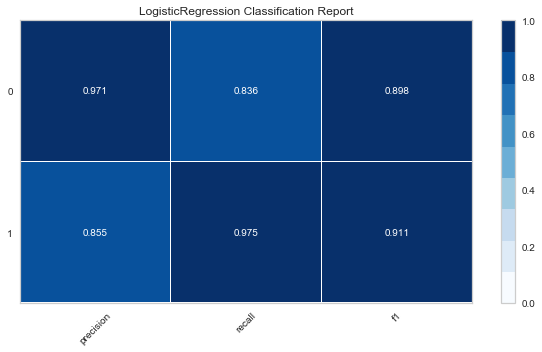

0.905

In [14]:
def score_model(clf):

    model = Pipeline([
        ('extract', clone(extractor)),
        ('clf', clone(clf)),
    ])

    cr = ClassificationReport(model, classes=[1,0], cmap="Blues", size=(600, 360)).fit(X_train, y_train)  
    score = cr.score(X_test, y_test)
    cr.poof()
    return score


score_model(LogisticRegression(max_iter=6000))

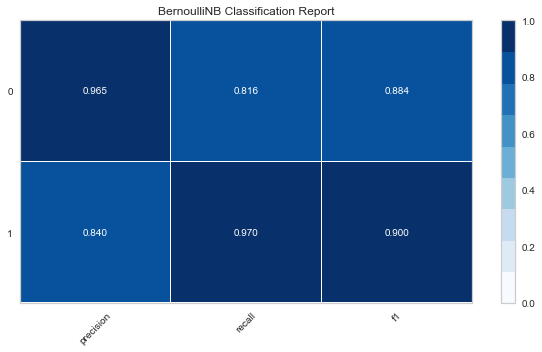

0.8929

In [12]:
score_model(BernoulliNB())

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


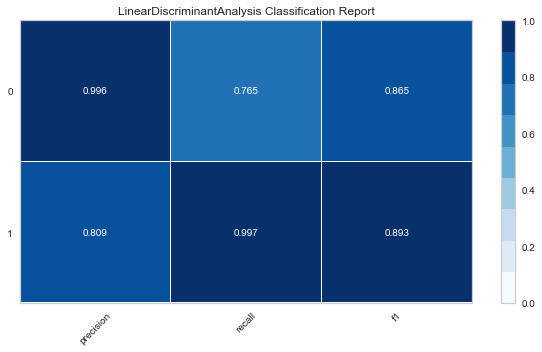

0.8807

In [13]:
score_model(LinearDiscriminantAnalysis())

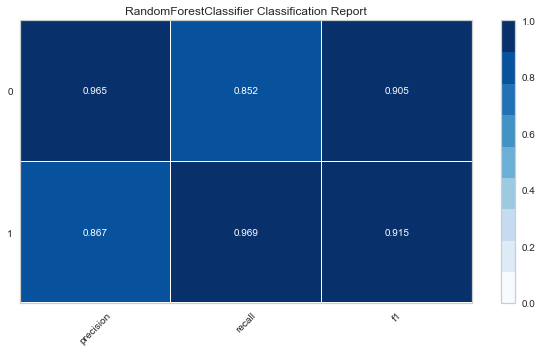

0.9101

In [15]:
score_model(RandomForestClassifier(n_estimators=100))

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


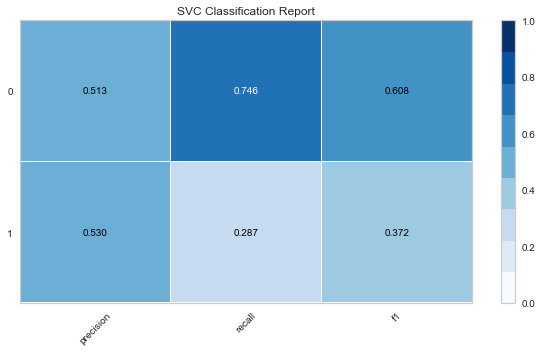

0.5172

In [20]:
score_model(SVC(max_iter=10000))